In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import numpy as np
import seaborn as sb

from IPython.display import Image
from math import sqrt
from matplotlib import pyplot as plt
from scipy import stats
from statistics import mean, stdev
from statsmodels.stats.power import TTestIndPower



In [2]:
np.random.seed(42)

In [3]:
# Intro about hypothesis testing, what is it for, why important 
# Assumptions -- normality etc.
# Sample size -- we won't discuss that here, but power analysis is a thing
# Normality test also a thing QQ plot or a specific inferential test -- not for today
# What is a p-value
# p-value in biology -- see papers on just reporting p value vs accept reject (product engineering)

# Introduction
The purpose of this Notebook is to explain the concept of the *p*-value, through the example of a hypothesis test. The goal is to give the reader a visual as well as mathematical explanation to develop a visual intuititon about the meaning of the concept. 

## The importance of hypothesis testing?
* Analytical rigor
* Escape the trap of finding spurious patterns in noise
* History early 20th century, food production. Today's tool, the t-test, developed by Gossett, a statistician at Guiness Brewery!

## What do we do in hypothesis testing?
* In its most basic form we ask, are A and B the same or different? 
* We can be more specific and ask, is A larger than B? Is A smaller than B? 

## Hypothesis testing has some limits, like most tools
* Even if a difference exists, can we detect it with the number of observations we have? 
* How many observations might we need to detect it?
* Even if we do not detect a difference, one may still exist. 
* The accept/reject framework -- not always appropriate.


# Today's Tool, the two sample t-test
## Why?
* Used when population variance is unknown

## Assumptions
* Independent observations between the two samples
* Normality (for small sample, for 40+ see CLT)
* Homgeneity of variances of both samples
    * For non-homogeneity of variance we would use Welch's Test
* Observations obtained by random sampling

## Comment
We can test for normality with the Wilks-Shapiro test, QQ plots, and histograms. 
The t-distribution is slightly heavier tailed, i.e. more values are located in the tail ends vs the center. There is more uncertainty, b/c we don't know the standard error of the population. Eventually the t-distribution converges to the normal with sufficiently large sample size. 

# Simulate two different distributions 

* Each distribution has different means 
* Each distribution has the same variance
* Relatively small sample of 40 observations for each distribution

In [4]:
# Create two distributions with different mean from standard normal
dist1_mu = 4.75
dist2_mu = 5.0
same_sigma = 1
n1 = 40


In [5]:
def two_dists(mu1, mu2, n1, n2, sigma1, sigma2=None, ):
    if not sigma2:
        sigma2=sigma1
    dist1 = np.random.normal(mu1, sigma1, n1)
    dist2 = np.random.normal(mu2, sigma2, n2)
    return dist1, dist2

In [6]:
dist1, dist2 = two_dists(mu1=dist1_mu, mu2=dist2_mu, sigma1=1, n1=40, n2=40)

# Plot histograms of the two distributions

In [7]:
def plot_two_dists(first_dist, second_dist):
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    bins = np.linspace(-1,10,20)
    mean1 = round(mean(first_dist),2)
    mean2 = round(mean(second_dist),2)
    plt.hist(dist1, bins, alpha=0.5, label=f'Distribution Mean {mean1}')
    plt.hist(dist2, bins, alpha=0.5, label=f'Distribution Mean {mean2}')
    plt.legend(loc='upper right', prop={'size':15})
    plt.title('Histogram of Two Distributions', fontsize=15)
    plt.show()
    

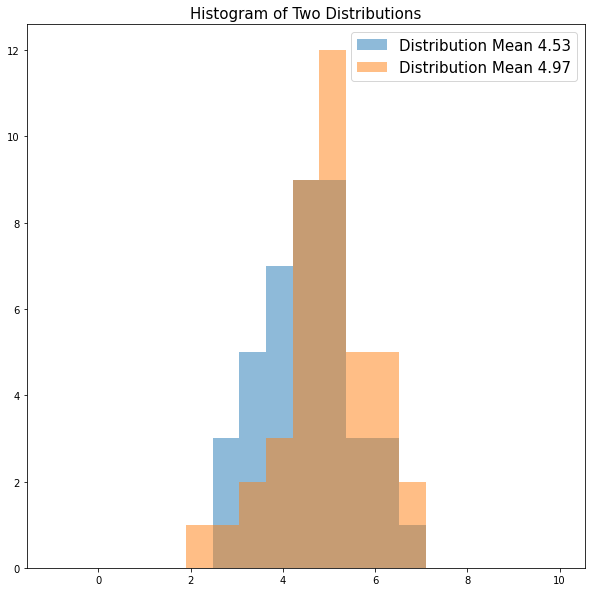

In [8]:
plot_two_dists(dist1,dist2)

## Comment:
The mean of the samples is a little different from the population distribution, which is what we expect given that we are sampling from a simulated random variable. 

## Set the $H_{0}$ and $H_{A}$
$H_{0}$ is the null hypothesis

$H_{A}$ is the alternative hypothesis

$H_{0}: \mu_1 = \mu_2$
Distribution 1 and Distribution 2 have the same mean.

$H_{A}: \mu_1 \neq \mu_2$
Distribution 1 and Distribution 2 have the same mean.

## Goal of our test
See if we can disprove the null hypothesis! That is, can we reject the null hypothesis? If we do reject the null hypothesis then we  say that the two distributions are likely different.

We set the $\alpha$ level of the test to 0.05. That means that if the *p*-value of the test is less than 0.05, we reject the null hypothesis. The 0.05 level is commonly accepted -- it is a social convention which can vary in practice. 

## What is the *p*-value??
The p-value is 
>the probability under a specified statistical model that a statistical summary of the data  (e.g., the sample mean difference between two compared groups) would be equal to or more extreme than its observed value.
>
>[The ASA Statement on p-Values:Context, Process, and Purpose](https://www.tandfonline.com/doi/full/10.1080/00031305.2016.1154108), The American Statistician, Volume 70, 2016, Issue 2, Wasserstein & Lazar. 

In other words, how likely is it that we see data like these (or even more extreme) if the null hypothesis is true?


## Comment
The reject/not rejected framework is used often in an engineering context where a software build, for example, has to be held to a certain criteria or rejected from production. 

However, in a scientific research context, there are some statisticians who say that we should get away from the reject/not rejected framework and towards simply reporting on the probability value, i.e., the p-value. See: [Moving to a World Beyond “p < 0.05”](https://www.tandfonline.com/doi/full/10.1080/00031305.2019.1583913), The American Statistician, Volume 73, 2019, Issue 1, Wasserstein, Schirm, & Lazar.



## Transform the difference in means to a t-statistic
### General case
# $t_\hat{\beta} = \frac{\hat{\beta} - {\beta}_{0}}{SE({\hat{\beta}})}$
### Two Sample
# $t_\hat{\beta} = \frac{y_{1} - y_{2}}{SE(\bar{y_1}-\bar{y_2})}$
Where the standard error, SE, is:
# $SE=\sqrt{\frac{(n_1 - 1)s^2_1 + (n_2 - 1)s^2_2}{n_1 + n_2 -2} \times (\frac{1}{n_1} + \frac{1}{n_2})}$

The immediately above formula is used in the `stats.ttest_ind()` function code. 

# Comment:
The t-statistic takes the difference between the sample means and converts it into units of standard error, where in the instant case we pool the standard error between the two groups of observations. 

The t-distribution is the distribution of the t-statistic. 

In [9]:
t_result= stats.ttest_ind(dist1,dist2, alternative='two-sided')

In [10]:
print(t_result)

Ttest_indResult(statistic=-2.050382870249538, pvalue=0.0436864748378121)


In [11]:
print(f"The t-statistic is {t_result[0]}")
print(f"The p-value is {t_result[1]}")

The t-statistic is -2.050382870249538
The p-value is 0.0436864748378121


In [12]:
# Sanity check 
stats.t.cdf(t_result[0], df=78) * 2

0.0436864748378121

# Comment: 
In our case, we can say that the probability that the two distributions have no difference in means, given the observed data is equal to or at least as extreme as 0.04. 

Since we set the $\alpha$ level at 0.05, we reject the null hypothesis that the the means have no difference, and can conclude that there is a difference between the two distributions -- which is what we expect given that we simulated two different distributions. 

In [13]:
# ppf is a percent point function, the inverse of cdf at q of given random variable
# Cumulative distrivution function of X, evaluated at x is the probability that X will take a value less than
# or equal to x.
# Degrees of freedom assumes equal variance -- caveat for unequal variance see Welch's test
degrees_of_freedom = len(dist1) + len(dist2) - 2
lower_critical_value = stats.t.ppf(q=0.025, df=degrees_of_freedom)
upper_critical_value = stats.t.ppf(q=0.975, df=degrees_of_freedom)

In [14]:
print(f'For \N{GREEK SMALL LETTER ALPHA} level of 0.05 and {degrees_of_freedom} degrees of freedom, the critical values are {lower_critical_value} and {upper_critical_value}')

For α level of 0.05 and 78 degrees of freedom, the critical values are -1.9908470685550523 and 1.990847068555052


# Probability distribution function (PDF) for the t-distribution

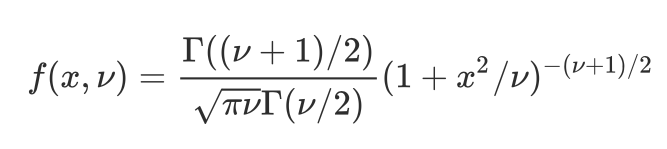

In [15]:
Image(filename='pdf_t_dist.png')

Where $x$ is a real number and $v$ is the degrees of freedom, with $v > 0$. 

$\Gamma$ is the gamma function. 

For more, see [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).

# Visual Representation

In [16]:

def t_dist_plot(fig_size,distribution1, distribution2, lower_crit_val, upper_crit_val, t_stat, two_tail=True ):
    sb.set(rc={"figure.figsize":(fig_size[0], fig_size[1])})
    degrees_of_freedom = len(distribution1) + len(distribution2) - 2
    t_sample= stats.t.rvs(df=degrees_of_freedom,size=10000)
    ax = sb.kdeplot(t_sample, legend=True)
    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    ax.vlines(lower_crit_val, 0, np.interp(lower_critical_value, x, y), linestyle='-', color='black', alpha=.4)
    ax.fill_between(x, 0, y, where=x < lower_critical_value, color='gold', alpha=0.3)
    ax.vlines(upper_crit_val, 0, np.interp(upper_crit_val, x, y), linestyle='-', color='black', alpha=.4)
    ax.fill_between(x, 0, y, where=x > upper_crit_val, color='gold', alpha=0.3)
    ax.vlines(t_stat,0, np.interp(t_stat,x,y), linestyle='-', color='red', alpha=0.8)
    if two_tail:
        ax.vlines(-t_stat,0, np.interp(t_stat,x,y), linestyle='-', color='red', alpha=0.8)


        


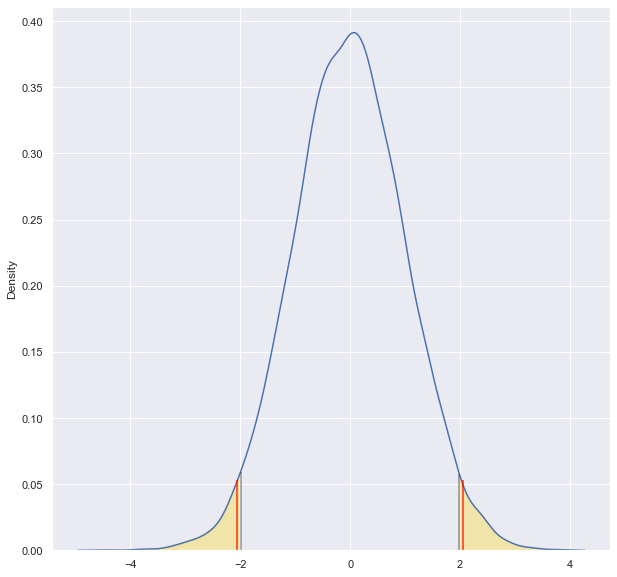

In [17]:
t_dist_plot(fig_size=[10,10],
            distribution1=dist1,
            distribution2=dist2,
            lower_crit_val=lower_critical_value,
            upper_crit_val=upper_critical_value,
            t_stat=t_result[0],
            two_tail=True)

# Comment:
Above we see a t-distribution with 78 degrees of freedom. This distribution is the one on which we plot the t-statistic calculated from the two distribution means and pooled variance. 

The total area under the curve sums up to 1.0. Since we are equally interested in departures from zero difference in either a positive or negative direction, we have two rejection regions here at the extremes of the distribution. 

We see the yellow areas are the rejection regions, that is, areas that together represent a total probability of 0.05. The gray lines on the inner part of the yellow regions represent the boundary of each region. 

Since we are looking for only the difference of the means, then we look at both tails of the distribution. The t-statistic is plotted by the red lines, since this is a two tailed test. Thus we see that the t-statistic is within the rejection region. 

If we sum up the yellow area to the left of the red line on the left and the right of the red line on the right, we would find it to be 0.04. That is the visual representation of the *p*-value.


# Undetected Differences 

In [18]:
dist1_mu = 4.95
dist2_mu = 5.0
same_sigma = 1
n1 = 40

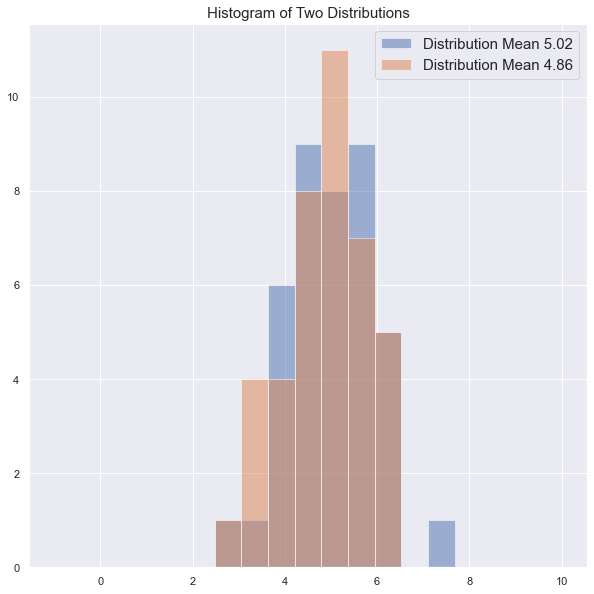

In [19]:
dist1, dist2 = two_dists(mu1=dist1_mu, mu2=dist2_mu, sigma1=1, n1=40, n2=40)
plot_two_dists(dist1,dist2)


In [20]:
lower_critical_value = stats.t.ppf(q=0.025, df=degrees_of_freedom)
upper_critical_value = stats.t.ppf(q=0.975, df=degrees_of_freedom)

In [21]:
effect_size = (mean(dist1)-mean(dist2))/(len(dist1)+len(dist2) -2)

In [22]:
effect_size

0.0019738316795148547

In [24]:
t_result= stats.ttest_ind(dist1,dist2, alternative='two-sided')
print(f'For \N{GREEK SMALL LETTER ALPHA} level of 0.05, critical values are {lower_critical_value} and {upper_critical_value}')
print(f't-statistic is {t_result[0]}')
print(f'p-value is {t_result[1]}')

For α level of 0.05, critical values are -1.9908470685550523 and 1.990847068555052
t-statistic is 0.7456942191197077
p-value is 0.4580935052277444


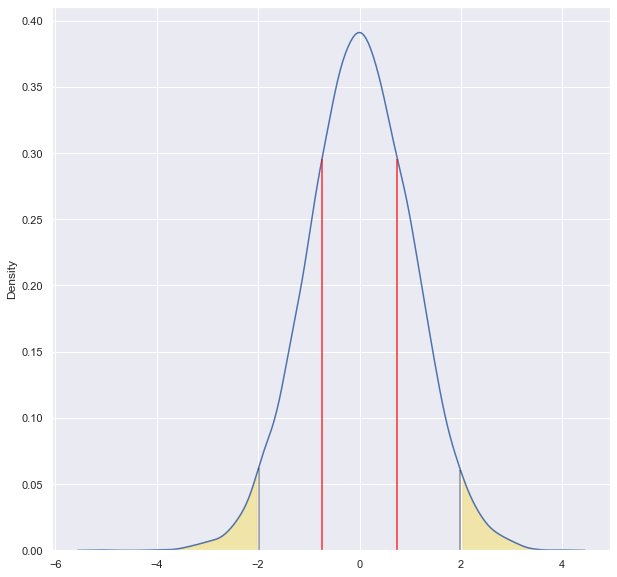

In [25]:
t_dist_plot(fig_size=[10,10],
            distribution1=dist1,
            distribution2=dist2,
            lower_crit_val=lower_critical_value,
            upper_crit_val=upper_critical_value,
            t_stat=t_result[0])

# Comment:

The plot above shows that we can fail to reject the null even where there is an actual difference between the distributions. The returned *p*-value is ~0.45, and we can see that the area under the curve bounded by the red lines (representing the t-statistic) is pretty close to 50% of the area under the curve. 

# Sample Size to Detect Difference of 0.05? 

In [26]:
# Power Analysis
# Find the effect size given the data
# Cohen's distance, (mean_a-mean_b)/pooled_std_dev
def cohen_d(mean_1, mean_2, var_1, var_2, n_1, n_2):
    pooled_std_dev = sqrt(((n_1 - 1)*var_1) + ((n_2-1)* var_2))/sqrt(n_1 + n_2-2)
    cohens_d = (mean_1 - mean_2)/ pooled_std_dev
    return cohens_d
    

# Plug the alpha level in , 0.05

In [27]:
small_cohen_dist = cohen_d(mean_1=5.0, mean_2=4.95, var_1=1, var_2=1, n_1=40, n_2=40)
print(small_cohen_dist)

0.04999999999999982


# Comment: 
This is considered a very small effect size, see [here](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d).
Note that Cohen's Distance calculation uses pooled standard deviation, as opposed to the pooled standard error of the t-statistic. For more on that difference, see [here](https://en.wikipedia.org/wiki/Standard_deviation).


In [28]:
power_analysis = TTestIndPower()
effect_size = small_cohen_dist
sample_size = power_analysis.solve_power(effect_size=effect_size,
                                         power=0.8,
                                        alpha=0.05)

In [29]:
sample_size =round(sample_size)
print(sample_size)

6280


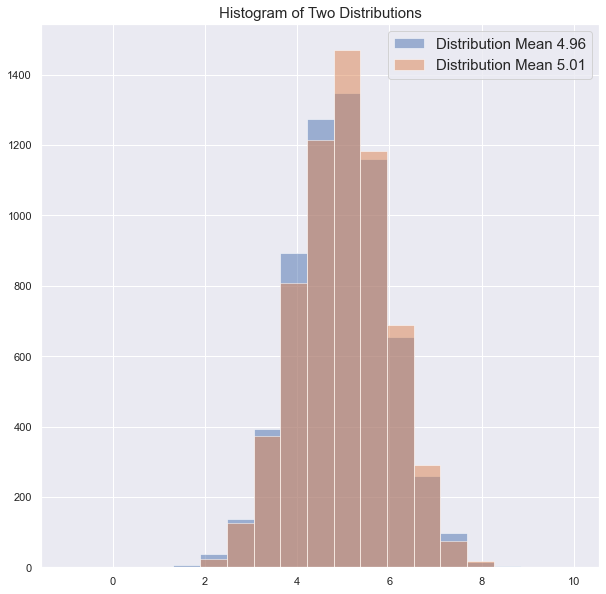

In [30]:
dist1, dist2 = two_dists(mu1=dist1_mu, mu2=dist2_mu, sigma1=1, n1=sample_size, n2=sample_size)
plot_two_dists(dist1,dist2)

In [31]:
t_result= stats.ttest_ind(dist1,dist2, alternative='two-sided')
print(f'For \N{GREEK SMALL LETTER ALPHA} level of 0.05, critical values are {lower_critical_value} and {upper_critical_value}')
print(f't-statistic is {t_result[0]}')
print(f'p-value is {t_result[1]}')

For α level of 0.05, critical values are -1.9908470685550523 and 1.990847068555052
t-statistic is -2.747632485624194
p-value is 0.006011288694753985


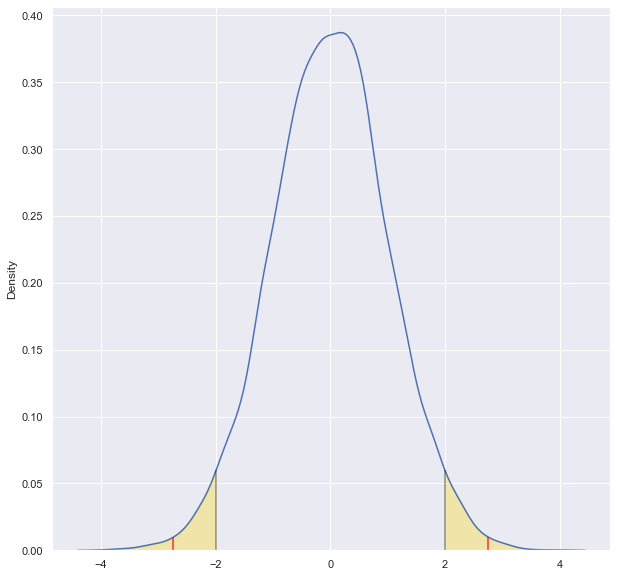

In [32]:
t_dist_plot(fig_size=[10,10],
            distribution1=dist1,
            distribution2=dist2,
            lower_crit_val=lower_critical_value,
            upper_crit_val=upper_critical_value,
            t_stat=t_result[0])

# Comment:
Here we see that the sample size is now adequate to reject the true null, i.e. the test can now detect the 0.05 difference between the distribution means. 